#Intro


For our project, we decided to take the perspective of a consulting company marketing services to nursing homes. Our goal was to use unsupervised learning and text analysis to identify distinct segments of customers, and develop unique marketing strategies for different groups.

Dataset
Our primary dataset is the Centers for Medicare and Medicaid Services (CMS) Nursing Home Inspection data. It contains 18 tables containing a variety of information on over 15,000 US nursing homes. Our analysis focuses on one particular table “Provider Info”, which contains aggregated annual figures for all nursing homes in the dataset. 




Caring.com website for reviews:

https://www.caring.com/senior-living/nursing-homes/ohio/akron

Data:

https://data.cms.gov/provider-data/search?theme=Nursing%20homes%20including%20rehab%20services

Quality Rating Doc:

>short 

https://www.cms.gov/Medicare/Provider-Enrollment-and-Certification/CertificationandComplianc/Downloads/consumerfactsheet.pdf

> long

https://www.cms.gov/Medicare/Provider-Enrollment-and-Certification/CertificationandComplianc/Downloads/usersguide.pdf

In [ ]:
! pip install scikit-plot

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn import metrics

import scikitplot as skplt

In [ ]:
import random
random.seed(820)

# EDA/Pre-Processing

In [ ]:
df = pd.read_csv('https://data.cms.gov/provider-data/sites/default/files/resources/ebad0df2291a5d8ced7b370f8bb1eddf_1613016319/NH_ProviderInfo_Feb2021.csv',encoding='cp1252')
df.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,...,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Corporation,57,51.8,NaN,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",1969-09-01,N,NaN,N,N,N,Both,Yes,5.0,NaN,5.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,...,0.35980,3.25651,2.50041,0.84582,0.93430,4.23509,2019-08-21,2,2,0,8,1,0,8,2018-08-01,1,1,0,4,1,0,4,2017-06-22,0,0,0,0,0,0,0,5.333,0,0,0.0,0,0,0,0,"701 MONROE STREET NW,RUSSELLVILLE,AL,35653",2021-02-01
1,015010,COOSA VALLEY HEALTHCARE CENTER,260 WEST WALNUT STREET,SYLACAUGA,AL,35150,2562495604,600,Talladega,For profit - Corporation,85,72.1,NaN,Medicare and Medicaid,N,COOSA VALLEY HEALTHCARE CENTER LLC,1967-01-01,N,NaN,N,N,N,Both,Yes,4.0,NaN,3.0,NaN,4.0,NaN,2.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,...,0.27134,2.86995,3.10041,1.02657,1.47042,5.39346,2019-06-13,1,1,0,4,1,0,4,2018-06-07,4,4,0,32,1,0,32,2017-04-06,7,7,0,36,1,0,36,18.667,0,0,0.0,1,650,0,1,"260 WEST WALNUT STREET,SYLACAUGA,AL,35150",2021-02-01
2,015012,HIGHLANDS HEALTH AND REHAB,380 WOODS COVE ROAD,SCOTTSBORO,AL,35768,2562183708,350,Jackson,Government - County,50,41.3,NaN,Medicare and Medicaid,Y,JACKSON COUNTY HEALTH CARE AUTHORITY,1967-01-01,N,NaN,N,N,N,Resident,Yes,3.0,NaN,2.0,NaN,3.0,NaN,2.0,NaN,3.0,NaN,5.0,NaN,5.0,NaN,

In [ ]:
df.shape

(15331, 88)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15331 entries, 0 to 15330
Data columns (total 88 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Federal Provider Number                                          15331 non-null  object 
 1   Provider Name                                                    15331 non-null  object 
 2   Provider Address                                                 15331 non-null  object 
 3   Provider City                                                    15331 non-null  object 
 4   Provider State                                                   15331 non-null  object 
 5   Provider Zip Code                                                15331 non-null  int64  
 6   Provider Phone Number                                            15331 non-null  int64  
 7   Provider SSA County Code                

In [ ]:
df.dtypes

Federal Provider Number             object
Provider Name                       object
Provider Address                    object
Provider City                       object
Provider State                      object
                                     ...  
Total Amount of Fines in Dollars     int64
Number of Payment Denials            int64
Total Number of Penalties            int64
Location                            object
Processing Date                     object
Length: 88, dtype: object

In [ ]:
cols = [c for c in df.columns if c[-8:] != 'Footnote']
df1 = df[cols]

In [ ]:
df1.columns

Index(['Federal Provider Number', 'Provider Name', 'Provider Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
       'Provider Phone Number', 'Provider SSA County Code',
       'Provider County Name', 'Ownership Type', 'Number of Certified Beds',
       'Average Number of Residents per Day', 'Provider Type',
       'Provider Resides in Hospital', 'Legal Business Name',
       'Date First Approved to Provide Medicare and Medicaid Services',
       'Continuing Care Retirement Community', 'Special Focus Status',
       'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago',
       'Provider Changed Ownership in Last 12 Months',
       'With a Resident and Family Council',
       'Automatic Sprinkler Systems in All Required Areas', 'Overall Rating',
       'Health Inspection Rating', 'QM Rating', 'Long-Stay QM Rating',
       'Short-Stay QM Rating', 'Staffing Rating', 'RN Staffing Rating',
       'Reported Nurse Aide Staffing Hours per Resident per Day'

In [ ]:
df1.drop(['Provider Zip Code', 'Provider Phone Number',
       'Special Focus Status'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df2 = df1.dropna(axis = 0, how ='any') 

In [ ]:
df1.shape

(15331, 75)

In [ ]:
df2.shape

(11902, 75)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11902 entries, 0 to 15282
Data columns (total 75 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Federal Provider Number                                          11902 non-null  object 
 1   Provider Name                                                    11902 non-null  object 
 2   Provider Address                                                 11902 non-null  object 
 3   Provider City                                                    11902 non-null  object 
 4   Provider State                                                   11902 non-null  object 
 5   Provider SSA County Code                                         11902 non-null  int64  
 6   Provider County Name                                             11902 non-null  object 
 7   Ownership Type                          

In [ ]:
df2.groupby('Overall Rating').size()/df2.shape[0]

Overall Rating
1.0    0.143253
2.0    0.194925
3.0    0.185599
4.0    0.224920
5.0    0.251302
dtype: float64

In [ ]:
df2.groupby('Provider Type').size()/df2.shape[0]

Provider Type
Medicare                 0.026466
Medicare and Medicaid    0.973534
dtype: float64

In [ ]:
df2.groupby('Automatic Sprinkler Systems in All Required Areas').size()/df2.shape[0]

Automatic Sprinkler Systems in All Required Areas
Partial    0.001344
Yes        0.998656
dtype: float64

In [ ]:
####First 5 states with most nursing homes####
x = df2.groupby('Provider State').size()
x.nlargest(n=5)

Provider State
CA    898
TX    874
OH    727
FL    627
PA    602
dtype: int64

In [ ]:
#Corporation is most popular ownership type despite for profit or non profit
x1 = df2.groupby('Ownership Type').size()/df2.shape[0]
x1.nlargest(n=13)

Ownership Type
For profit - Corporation                  0.527978
Non profit - Corporation                  0.171736
For profit - Limited Liability company    0.098639
For profit - Partnership                  0.055537
For profit - Individual                   0.049740
Non profit - Church related               0.026382
Non profit - Other                        0.024870
Government - County                       0.023609
Government - Hospital district            0.009662
Government - State                        0.004117
Government - City/county                  0.003697
Government - City                         0.003193
Government - Federal                      0.000840
dtype: float64

In [ ]:
df2.groupby('Ownership Type').size()

Ownership Type
For profit - Corporation                  6284
For profit - Individual                    592
For profit - Limited Liability company    1174
For profit - Partnership                   661
Government - City                           38
Government - City/county                    44
Government - County                        281
Government - Federal                        10
Government - Hospital district             115
Government - State                          49
Non profit - Church related                314
Non profit - Corporation                  2044
Non profit - Other                         296
dtype: int64

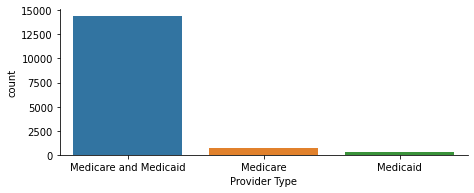

In [ ]:
sns.catplot(x="Provider Type", kind="count", data=df, height=2.6, aspect=2.5);

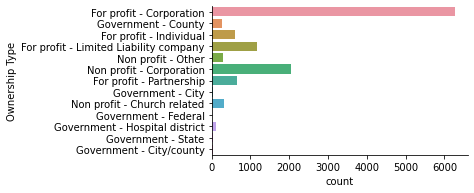

In [ ]:
####Ownership Type####
sns.catplot(y="Ownership Type", kind="count", data=df2, height=2.6, aspect=2.5);

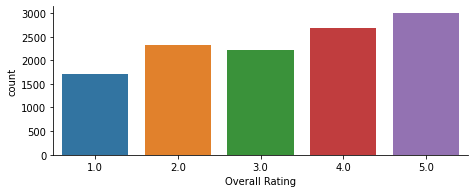

In [ ]:
####Overall Rating####
sns.catplot(x="Overall Rating", kind="count", data=df2, height=2.6, aspect=2.5);

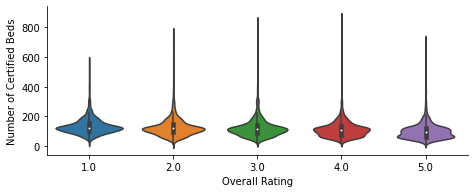

In [ ]:
####Is there any relationship between overall rating and number of certified beds?
sns.catplot(x="Overall Rating", y= 'Number of Certified Beds',kind='violin', data=df2, height=2.6, aspect=2.5);

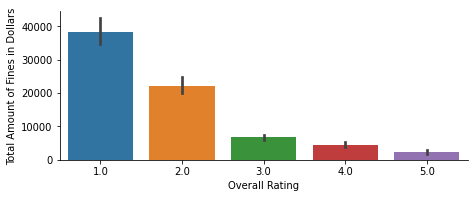

In [ ]:
####Relationship between Overall Rating and Fines####
sns.catplot(x="Overall Rating", y="Total Amount of Fines in Dollars",kind= 'bar', data=df2, height=2.6, aspect=2.5);

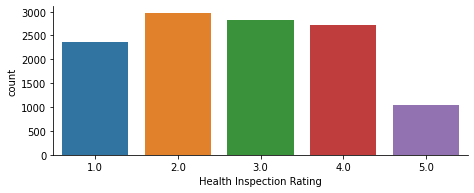

In [ ]:
sns.catplot(x="Health Inspection Rating", kind="count", data=df2, height=2.6, aspect=2.5);

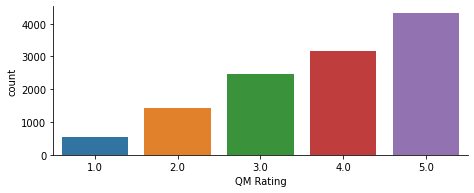

In [ ]:
sns.catplot(x="QM Rating", kind="count", data=df2, height=2.6, aspect=2.5);

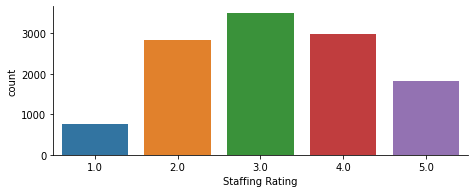

In [ ]:
sns.catplot(x="Staffing Rating", kind="count", data=df2, height=2.6, aspect=2.5);

In [ ]:
#The average of count of certified beds with different ownership type in different overall rating
df2.pivot_table(values='Number of Certified Beds', index=['Ownership Type'], columns='Overall Rating', aggfunc='mean')

Overall Rating,1.0,2.0,3.0,4.0,5.0
Ownership Type,,,,,
For profit - Corporation,129.873926,120.720180,113.730579,107.904796,100.399383
For profit - Individual,136.272727,128.775194,112.900000,110.598291,99.158730
For profit - Limited Liability company,134.513274,126.950192,123.859729,116.222222,109.878049
For profit - Partnership,141.961538,132.228188,139.903704,125.865546,106.453125
Government - City,89.000000,80.000000,65.833333,162.363636,109.000000
Government - City/county,124.000000,196.111111,149.285714,138.000000,95.071429
Government - County,171.000000,155.818182,140.277778,150.612500,112.097561
Government - Federal,93.000000,89.000000,109.000000,85.000000,113.500000
Government - Hospital district,139.608696,129.000000,121.695652,104.470588,97.428571


In [ ]:
#The average of count of certified beds with different provider type in different overall rating
df2.pivot_table(values='Number of Certified Beds', index=['Provider Type'], columns='Overall Rating', aggfunc='mean')

Overall Rating,1.0,2.0,3.0,4.0,5.0
Provider Type,,,,,
Medicare,63.000000,91.875000,97.518519,68.272727,60.493023
Medicare and Medicaid,132.859072,124.288194,119.706233,112.912662,102.783501


In [ ]:
####The average of number of residents per day with different ownership type in different overall rating####
df2.pivot_table(values='Average Number of Residents per Day', index=['Ownership Type'], columns='Overall Rating', aggfunc='mean')

Overall Rating,1.0,2.0,3.0,4.0,5.0
Ownership Type,,,,,
For profit - Corporation,89.316619,85.603601,81.318678,76.493057,72.648188
For profit - Individual,90.799091,90.900775,79.385455,78.259829,71.531746
For profit - Limited Liability company,94.004867,86.930651,84.928959,84.139464,79.651707
For profit - Partnership,102.458462,94.873826,102.025926,91.063866,74.422656
Government - City,71.050000,63.060000,45.766667,107.727273,91.278571
Government - City/county,106.700000,154.866667,107.550000,100.366667,70.892857
Government - County,114.557143,113.252273,98.768519,105.460000,85.078049
Government - Federal,67.250000,56.975000,87.700000,66.400000,64.400000
Government - Hospital district,84.769565,86.616667,81.095652,66.488235,63.032143


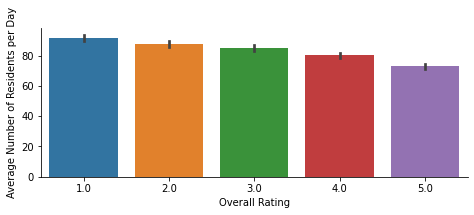

In [ ]:
sns.catplot(x="Overall Rating", y= 'Average Number of Residents per Day',kind='bar', data=df2, height=2.6, aspect=2.5);

In [ ]:
#The average of number of residents per day with different provider type in different overall rating
df2.pivot_table(values='Average Number of Residents per Day', index=['Provider Type'], columns='Overall Rating', aggfunc='mean')

Overall Rating,1.0,2.0,3.0,4.0,5.0
Provider Type,,,,,
Medicare,48.950000,51.643750,50.588889,41.638182,39.394419
Medicare and Medicaid,91.609102,88.023698,85.334647,81.067773,75.377594


## Numeric Dtypes

In [ ]:
dfn = df.select_dtypes('number')
dfn.shape

(15331, 44)

In [ ]:
dfn.head()

,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties
0,35653,2563324110,290,57,51.8,NaN,5.0,NaN,5.0,NaN,5.0,NaN,4.0,NaN,5.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,2.62754,0.83202,0.85303,1.68505,4.31259,0.00000,2.16793,0.72878,0.35980,3.25651,2.50041,0.84582,0.93430,4.23509,5.333,0,0,0.0,0,0,0,0
1,35150,2562495604,600,85,72.1,NaN,4.0,NaN,3.0,NaN,4.0,NaN,2.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,2.91141,0.91635,1.01245,1.92880,4.84021,0.01271,1.93727,0.66133,0.27134,2.86995,3.10041,1.02657,1.47042,5.39346,18.667,0,0,0.0,1,650,0,1
2,35768,2562183708,350,50,41.3,NaN,3.0,NaN,2.0,NaN,3.0,NaN,2.0,NaN,3.0,NaN,5.0,NaN,5.0,NaN,NaN,NaN,2.96649,0.58426,1.21570,1.79996,4.76645,0.05596,2.18116,0.74001,0.36758,3.28875,2.80584,0.58494,1.30336,4.63492,30.667,0,0,0.0,0,0,0,0
3,35206,2058330146,360,92,71.8,NaN,3.0,NaN,4.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,2.35268,0.76296,0.70356,1.46652,3.81920,0.03246,1.97728,0.66683,0.33478,2.97890,2.45470,0.84767,0.82819,4.10010,12.667,0,0,0.0,0,0,0,0
4,35111,2054776161,360,103,83.8,NaN,3.0,NaN,3.0,NaN,2.0,NaN,3.0,NaN,1.0,NaN,3.0,NaN,3.0,NaN,NaN,NaN,2.12942,0.91534,0.35473,1.27006,3.39949,0.01248,1.87521,0.62287,0.25398,2.75205,2.34272,1.08876,0.55041,3.95034,16.000,0,1,0.0,2,29611,0,2


In [ ]:
dfn.columns[11][-8:]

'Footnote'

In [ ]:
cols = [c for c in dfn.columns if c[-8:] != 'Footnote']
dfn = dfn[cols]

In [ ]:
dfn.columns

Index(['Provider Zip Code', 'Provider Phone Number',
       'Provider SSA County Code', 'Number of Certified Beds',
       'Average Number of Residents per Day', 'Overall Rating',
       'Health Inspection Rating', 'QM Rating', 'Long-Stay QM Rating',
       'Short-Stay QM Rating', 'Staffing Rating', 'RN Staffing Rating',
       'Reported Nurse Aide Staffing Hours per Resident per Day',
       'Reported LPN Staffing Hours per Resident per Day',
       'Reported RN Staffing Hours per Resident per Day',
       'Reported Licensed Staffing Hours per Resident per Day',
       'Reported Total Nurse Staffing Hours per Resident per Day',
       'Reported Physical Therapist Staffing Hours per Resident Per Day',
       'Case-Mix Nurse Aide Staffing Hours per Resident per Day',
       'Case-Mix LPN Staffing Hours per Resident per Day',
       'Case-Mix RN Staffing Hours per Resident per Day',
       'Case-Mix Total Nurse Staffing Hours per Resident per Day',
       'Adjusted Nurse Aide Staffing Ho

In [ ]:
dfn.drop(['Provider Zip Code', 'Provider Phone Number',
       'Provider SSA County Code'], axis = 1, inplace = True)

In [ ]:
dfn.head()

,Number of Certified Beds,Average Number of Residents per Day,Overall Rating,Health Inspection Rating,QM Rating,Long-Stay QM Rating,Short-Stay QM Rating,Staffing Rating,RN Staffing Rating,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties
0,57,51.8,5.0,5.0,5.0,4.0,5.0,4.0,4.0,2.62754,0.83202,0.85303,1.68505,4.31259,0.00000,2.16793,0.72878,0.35980,3.25651,2.50041,0.84582,0.93430,4.23509,5.333,0,0,0.0,0,0,0,0
1,85,72.1,4.0,3.0,4.0,2.0,5.0,5.0,5.0,2.91141,0.91635,1.01245,1.92880,4.84021,0.01271,1.93727,0.66133,0.27134,2.86995,3.10041,1.02657,1.47042,5.39346,18.667,0,0,0.0,1,650,0,1
2,50,41.3,3.0,2.0,3.0,2.0,3.0,5.0,5.0,2.96649,0.58426,1.21570,1.79996,4.76645,0.05596,2.18116,0.74001,0.36758,3.28875,2.80584,0.58494,1.30336,4.63492,30.667,0,0,0.0,0,0,0,0
3,92,71.8,3.0,4.0,1.0,1.0,1.0,4.0,4.0,2.35268,0.76296,0.70356,1.46652,3.81920,0.03246,1.97728,0.66683,0.33478,2.97890,2.45470,0.84767,0.82819,4.10010,12.667,0,0,0.0,0,0,0,0
4,103,83.8,3.0,3.0,2.0,3.0,1.0,3.0,3.0,2.12942,0.91534,0.35473,1.27006,3.39949,0.01248,1.87521,0.62287,0.25398,2.75205,2.34272,1.08876,0.55041,3.95034,16.000,0,1,0.0,2,29611,0,2


## Categorical Dtypes

In [ ]:
dfc = df[['Ownership Type', 'Provider Type', 'Provider Resides in Hospital', 'Continuing Care Retirement Community', 'Abuse Icon', 'With a Resident and Family Council', 'Automatic Sprinkler Systems in All Required Areas' ]]
dfc.head()

,Ownership Type,Provider Type,Provider Resides in Hospital,Continuing Care Retirement Community,Abuse Icon,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas
0,For profit - Corporation,Medicare and Medicaid,N,N,N,Both,Yes
1,For profit - Corporation,Medicare and Medicaid,N,N,N,Both,Yes
2,Government - County,Medicare and Medicaid,Y,N,N,Resident,Yes
3,For profit - Individual,Medicare and Medicaid,N,N,N,Both,Yes
4,For profit - Individual,Medicare and Medicaid,N,N,N,Resident,Yes


In [ ]:
dfcd = pd.get_dummies(dfc, drop_first=True)
dfcd.head()

,Ownership Type_For profit - Individual,Ownership Type_For profit - Limited Liability company,Ownership Type_For profit - Partnership,Ownership Type_Government - City,Ownership Type_Government - City/county,Ownership Type_Government - County,Ownership Type_Government - Federal,Ownership Type_Government - Hospital district,Ownership Type_Government - State,Ownership Type_Non profit - Church related,Ownership Type_Non profit - Corporation,Ownership Type_Non profit - Other,Provider Type_Medicare,Provider Type_Medicare and Medicaid,Provider Resides in Hospital_Y,Continuing Care Retirement Community_Y,Abuse Icon_Y,With a Resident and Family Council_Family,With a Resident and Family Council_None,With a Resident and Family Council_Resident,Automatic Sprinkler Systems in All Required Areas_Partial,Automatic Sprinkler Systems in All Required Areas_Yes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1


# Dimension Reduction

In [ ]:
sc = StandardScaler() # instantiate scaler
dfs = sc.fit_transform(dfn)
dfs = pd.DataFrame(dfs, columns = dfn.columns)

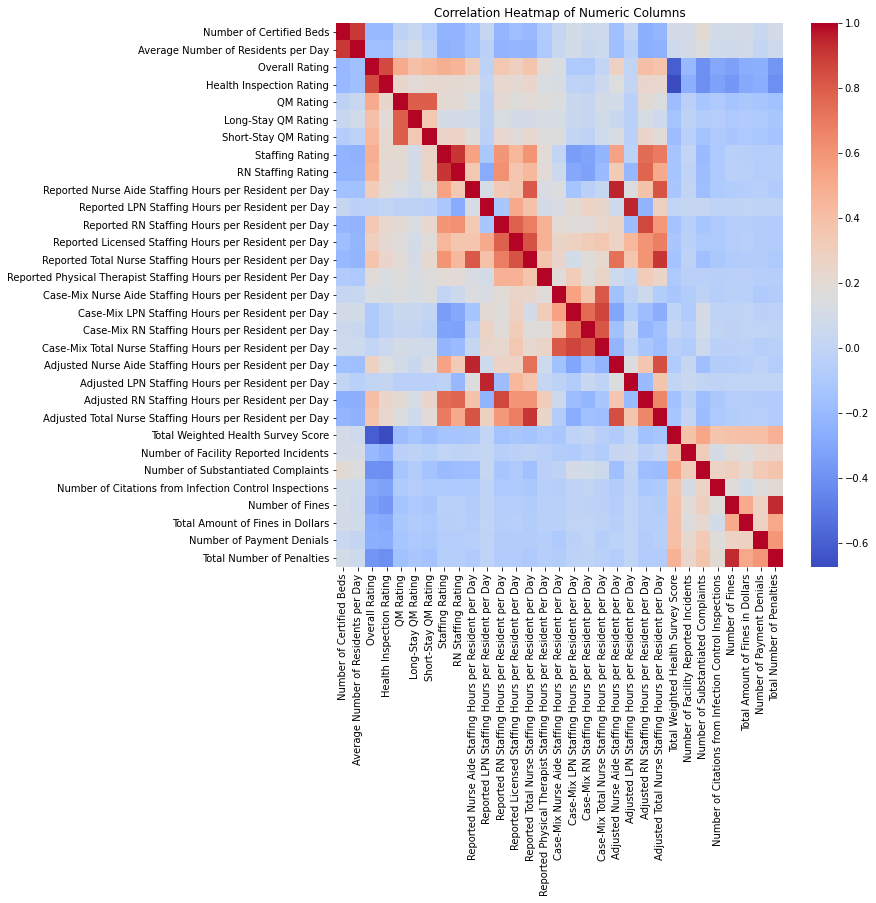

In [ ]:
cor = dfs.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Heatmap of Numeric Columns')
sns.heatmap(cor, cmap = 'coolwarm')
plt.show()

In [ ]:
dfnn = dfs.dropna()

In [ ]:
dfnn.shape[0] / dfs.shape[0]
# retain 78% of rows

0.7800534864001044

In [ ]:
pca = PCA()
pcs = pca.fit_transform(dfnn)

In [ ]:
dfn.shape

(15331, 31)

In [ ]:
dfn.dropna().shape

(11959, 31)

In [ ]:
pcs.shape

(11959, 31)

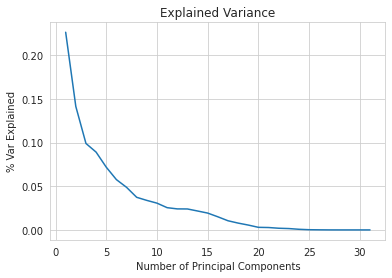

In [ ]:
with sns.axes_style("whitegrid"):
  plt.title("Explained Variance")
  plt.ylabel('% Var Explained')
  plt.xlabel('Number of Principal Components')
  varexp = pca.explained_variance_ratio_
  sns.lineplot(x = range(1, len(varexp)+1), y = varexp)

In [ ]:
pca.explained_variance_ratio_

array([2.26488813e-01, 1.41463542e-01, 9.90500804e-02, 8.91316473e-02,
       7.18771238e-02, 5.76384966e-02, 4.88080038e-02, 3.73608613e-02,
       3.38181497e-02, 3.06732002e-02, 2.54938220e-02, 2.40857989e-02,
       2.40079352e-02, 2.16783182e-02, 1.92797055e-02, 1.50322002e-02,
       1.04920454e-02, 7.81108217e-03, 5.55494101e-03, 2.96053912e-03,
       2.74124544e-03, 1.91710396e-03, 1.55544714e-03, 7.17494537e-04,
       2.34854316e-04, 1.06204979e-04, 2.13440550e-05, 8.18546108e-12,
       1.10860894e-12, 4.79120663e-13, 4.46670425e-32])

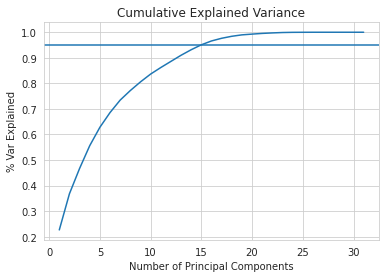

In [ ]:
with sns.axes_style("whitegrid"):
  plt.title("Cumulative Explained Variance")
  plt.ylabel('% Var Explained')
  plt.xlabel('Number of Principal Components')
  plt.plot(range(1, len(varexp)+1), np.cumsum(varexp))
  plt.axhline(.95)

In [ ]:
pcs.shape

(11959, 31)

In [ ]:
pcs[:,0:15].shape

(11959, 15)

In [ ]:
pc_df = pd.DataFrame(pcs)
pc_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,2.906772,-1.129503,-0.282227,-0.366857,-0.456494,-0.772229,-0.359326,-0.279401,0.454744,0.362873,0.089771,0.536587,-0.157389,0.389364,-0.834961,-0.582199,0.071783,0.008580,-0.118131,-0.151898,-0.170322,0.347149,-0.278228,0.075198,-0.011256,0.015589,-0.005927,-4.577171e-07,1.379874e-07,-8.706051e-08,-1.286803e-14
1,3.171863,2.270301,-1.173680,0.360452,0.102362,0.315596,-0.868480,-0.028216,-0.454762,-0.224480,-0.887733,0.218706,-1.237109,0.599565,-0.068030,-0.726238,-0.185509,-0.003193,-0.390608,-0.232610,0.176189,0.209952,-0.058912,-0.267957,0.068120,-0.044672,0.003480,2.455660e-05,9.216798e-07,-3.238209e-07,-1.611286e-14
2,2.310294,0.948345,-0.805765,0.137558,-2.337374,1.797817,0.496823,-0.501994,-0.110437,-0.713678,-0.485910,0.148561,-0.210830,-0.169194,-0.576540,-0.087130,-0.422072,-0.401635,-0.041717,-0.089432,0.356150,0.119241,-0.180158,0.062004,-0.016167,0.030409,-0.009371,-6.381054e-07,5.549246e-08,-8.734629e-08,2.801213e-14
3,0.348050,0.323525,-2.995386,1.849653,-1.360940,2.109491,-0.776473,0.423929,0.505756,0.398082,0.209046,0.113038,0.114050,0.164510,-0.074898,-0.195158,0.044473,-0.314664,0.266516,-0.186058,-0.198743,0.293815,-0.215141,0.042083,-0.006841,-0.009120,-0.008235,2.525845e-05,-1.597882e-07,9.486998e-08,1.956295e-15
4,-1.283508,1.714038,-2.708150,1.236925,0.096302,-0.233558,-2.606462,0.058414,-0.142280,0.305691,0.608242,-1.440334,-0.113610,-0.050692,-0.104370,-0.138074,-0.139408,-0.096387,0.150427,-0.182289,0.131972,0.071623,0.096390,0.062132,0.030856,0.015293,0.004568,-2.644486e-05,9.525131e-06,5.987994e-06,2.436256e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11954,0.291062,2.160559,3.568802,-1.962747,-2.630966,-0.767713,-0.221615,2.261466,-0.996681,-1.795873,-0.388540,-0.543681,-0.353368,0.031382,2.775617,-0.246483,-0.236930,-0.412111,-0.854451,0.088963,-0.010838,0.118240,-0.519651,0.502917,0.032401,-0.066743,-0.081192,2.377613e-05,1.032870e-05,6.406379e-06,1.186489e-15
11955,-0.781726,-2.494878,-0.830720,0.548072,0.834554,-1.603171,-0.524879,1.088524,0.012208,0.056544,-0.309833,0.546504,-0.160876,0.216601,0.286278,-0.769715,0.156444,0.336286,-0.152368,0.091034,-0.319598,-0.289949,0.041688,0.031528,-0.030564,0.051780,-0.033453,2.621766e-05,-6.154890e-08,1.396875e-07,2.577731e-16
11956,-0.241128,-1.584614,3.348928,3.638972,-1.273259,-0.078841,0.550766,-1.370835,0.835326,1.098791,0.746067,0.213538,0.050100,1.192541,-0.400562,-1.149262,-0.141116,-0.189681,0.106878,-0.148570,0.128884,-0.094504,0.009739,-0.340897,-0.233629,0.073085,0.038137,1.415263e-06,5.342348e-08,-2.878204e-07,5.116009e-17
11957,0.478823,-2.200958,-0.481000,-0.028374,0.487273,-1.498830,-0.137369,-0.932439,0.224562,0.462995,0.190184,0.670421,-0.308660,0.431426,0.013967,0.267633,0.219928,0.117839,-0.242643,-0.253638,0.443330,-0.023430,0.163484,0.026903,-0.025612,0.009805,0.001992,-5.212490e-08,3.691354e-08,-1.185406e-07,2.897065e-16


# Clustering

## K-Means 

First we loop over values from 2-30 to create and calculate scores for various K in K-Means Clustering 

In [ ]:
KRANGE = range(2,30)

inertias = []
ss = []

# loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(pcs)
  inertias.append(km.inertia_)
  ss.append(metrics.silhouette_score(pcs, lab))

In [ ]:
inertias[:5]
# descend over time

[270002.8458330559,
 245268.23483103735,
 231705.44615748659,
 220917.41186478024,
 213779.4690319485]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


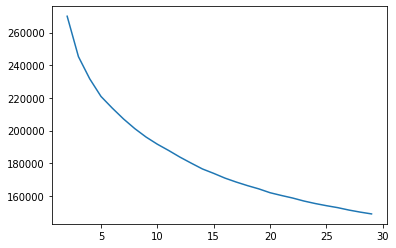

In [ ]:
# plot it up
sns.lineplot(KRANGE, inertias)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


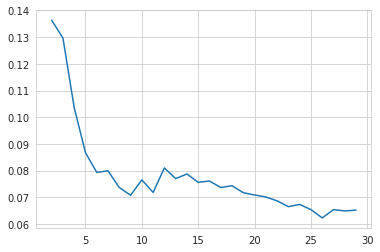

In [ ]:
with sns.axes_style("whitegrid"):
  sns.lineplot(KRANGE, ss)
plt.show()

Now we repeat using only 15 of our PCA columns

In [ ]:
KRANGE = range(2,30)

inertias = []
ss = []

# loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(pcs[:,0:15])
  inertias.append(km.inertia_)
  ss.append(metrics.silhouette_score(pcs, lab))

In [ ]:
inertias[:5]
# descend over time

[254558.47940386934,
 229824.65242385294,
 216246.54283084214,
 205622.71333996978,
 198437.64979641663]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


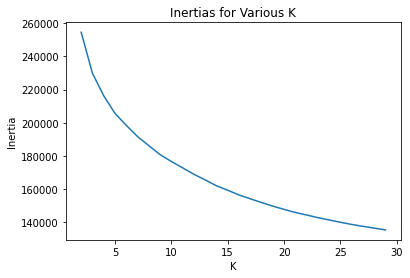

In [ ]:
sns.lineplot(KRANGE, inertias)
plt.title('Inertias for Various K')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()


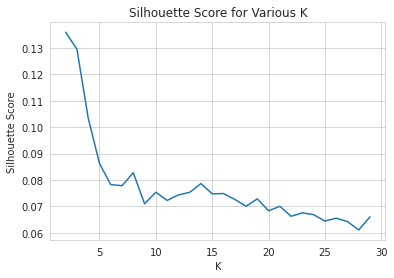

<Figure size 432x288 with 0 Axes>

In [ ]:
with sns.axes_style("whitegrid"):
  sns.lineplot(x = KRANGE,y  =  ss)
plt.title('Silhouette Score for Various K')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.figure()
plt.show()

In [ ]:
ss[7]
# index of 7 means k = 9 

In [ ]:
ss

### K - 6  

In [ ]:
k6 = KMeans(6)

In [ ]:
k6.fit(pcs)

In [ ]:
k6labs = k6.predict(pcs)
dfnn['k6labs'] = k6labs
dfnn.head()

In [ ]:
dfn['k6labs'] = dfnn['k6labs']
dfn.sample(10)

In [ ]:
dfn['k6labs'].value_counts()

In [ ]:
dfn.groupby('k6labs').mean().iloc[:,:15]

In [ ]:
dfn.groupby('k6labs').mean().iloc[:,16:]

**Silhouette Score**

In [ ]:
silo_overall = metrics.silhouette_score(pcs, k6labs)

silo_overall

In [ ]:
skplt.metrics.plot_silhouette(pcs, k6labs, figsize=(7,7))

In [ ]:
k4 = KMeans(4)
k4.fit(pcs)

In [ ]:
skplt.metrics.plot_silhouette(pcs, k4.predict(pcs), figsize=(7,7))

In [ ]:
k3 = KMeans(3)
k3.fit(pcs)
skplt.metrics.plot_silhouette(pcs, k3.predict(pcs), figsize=(7,7))

In [ ]:
k5 = KMeans(5)
k5.fit(pcs)
skplt.metrics.plot_silhouette(pcs, k5.predict(pcs), figsize=(7,7))

### K - 9

In [ ]:
k9 = KMeans(9)

In [ ]:
k9.fit(pcs)

In [ ]:
k9labs = k9.predict(pcs)
dfnn['k9labs'] = k9labs
dfnn.head()

In [ ]:
dfn['k9labs'] = dfnn['k9labs']
dfn.sample(10)

In [ ]:
dfn['k9labs'].value_counts()

In [ ]:
dfn.groupby('k9labs').mean().iloc[:,:15]

In [ ]:
dfn.groupby('k9labs').mean().iloc[:,16:]

### K-Means Evaluation

In [ ]:
dfk = df.copy()
dfk['k6'] = dfn.k6labs
dfk['k9'] = dfn.k9labs
dfk = dfk.dropna(subset = ['k6'], axis = 'rows')
dfk.shape

In [ ]:
cols = [c for c in dfk.columns if c[-8:] != 'Footnote']
dfk = dfk[cols]
dfk.shape

In [ ]:
dfk.value_counts('k6')

In [ ]:
dfk.value_counts('k6').plot.bar()

In [ ]:
dfk.select_dtypes('number').groupby('k6').mean().iloc[:,3:16]

In [ ]:
dfk.select_dtypes('number').groupby('k6').mean().iloc[:,16:34]

In [ ]:
dfk[['Ownership Type', 'Provider Type', 'Provider Resides in Hospital', 'Continuing Care Retirement Community', 'Abuse Icon', 'With a Resident and Family Council', 'Automatic Sprinkler Systems in All Required Areas' ]].head(2)


In [ ]:
tt = dfk[['Overall Rating', 'Health Inspection Rating', 'QM Rating', 'Staffing Rating','Reported Licensed Staffing Hours per Resident per Day' , 'Number of Facility Reported Incidents', 'Total Amount of Fines in Dollars', 'k6']].groupby('k6').mean().sort_values('Overall Rating', ascending = False)
tt

In [ ]:
tt.to_csv('table.csv')

Cluster 5:
* Has highest average overall rating of any group (4.41) out of 5
* Highest share of licensed staffing hours per resident (almost 50% higher than next closest group)
* Much more likely to be run by a church (6.5% of facilities in this group vs 2.2% in all other groups)

Cluster 3:
* Has average overall rating almost as high as cluster 5 (4.28)
* Achieves high rating with significantly less staff time per resident than cluster 5
* Highest average RN staff rating

Cluster 1:
* Middle of the pack average overall rating (3.43) 
* Has highest average Quality Measure (QM) rating of any cluster
  * QM rating measures changes in resident health like ability to move independently and other health outcomes. 
* Lowest average staffing rating of any cluster drags down high quality rating
* Highest average number of residents per day of any cluster

Cluster 2:
* Middle of the pack average overall rating (3.54) 
* Highest average number of facility reported incidents of any cluster, other than cluster 0

Cluster 4: 
* Very low average overall rating (2.01)
* Has the lowest average QM rating of any group by far 
* Lowest average licensed staffing hours per resident

Cluster 0:
* Lowest average overall rating of any cluster (1.63)
* Abysmal average health inspectionrating (1.24)
* Average total fines for this group is $82,000, more than 10x the average for any other group
* Does have higher average staffing rating than cluster 1


In [ ]:
(1308+325+134+128) / dfk[dfk['k6']== 2]['Ownership Type'].value_counts().sum()

In [ ]:
dfk[dfk['k6']== 2]['Ownership Type'].value_counts()

In [ ]:
dfk[dfk['k6']!= 2]['Ownership Type'].value_counts()

In [ ]:
77 / dfk[dfk['k6']== 5]['Ownership Type'].value_counts().sum()

In [ ]:
for k in range(0,6):
  print(dfk[dfk['k6']== k]['Ownership Type'].value_counts()['Non profit - Church related'] / dfk[dfk['k6']== k]['Ownership Type'].value_counts().sum())

In [ ]:
for k in range(0,6):
  print(dfk[dfk['k6']== k]['Ownership Type'].value_counts()['For profit - Corporation'] / dfk[dfk['k6']== k]['Ownership Type'].value_counts().sum())

In [ ]:
dfk[dfk['k6'] != 5]['Ownership Type'].value_counts()['Non profit - Church related'] / dfk[dfk['k6'] != 5]['Ownership Type'].value_counts().sum()

## TSNE

In [ ]:
tsne = TSNE(perplexity = 100)
tsne.fit(pcs)

In [ ]:
te = tsne.embedding_

te.shape

In [ ]:
te[:3]

In [ ]:
tdata = pd.DataFrame(te, columns=["e1", "e2"])
tdata['cluster'] = dfk.k6

tdata.head(3)

In [ ]:
tdata.cluster.value_counts(sort=False)

In [ ]:
PAL = sns.color_palette("bright", 6) 
plt.figure(figsize=(10, 8))
sns.scatterplot(x="e1", y="e2", hue="cluster", data=tdata, legend="full", palette=PAL)

## Hierarchical Clustering

> Numeric Distances

In [ ]:
dfn1 = dfn.dropna()
dfn1

In [ ]:
dfn_e = pdist(dfn1.values)
dfn_es = squareform(dfn_e)
dfn_es.shape, dfn_es[:1]

> Categorical Distance

In [ ]:
dfcd1 = dfcd.iloc[dfn1.index.values] # only taking categorical variables for which we have no null values in numeric columns
dfcd1

In [ ]:
dfc_j = pdist(dfcd1.values, metric = "jaccard")
dfc_js = squareform(dfc_j)

dfc_js.shape, dfc_js[:1]

In [ ]:
dfc_j.shape, dfn_e.shape

In [ ]:
combined_matrix = dfc_j + dfn_e
combined_matrix[:10]

In [ ]:
squareform(combined_matrix).shape

In [ ]:
hc1 = linkage(combined_matrix)
hc1[:2]

In [ ]:
hc1.shape

In [ ]:
dendrogram(hc1[:500])
plt.show()

#Sentiment Analysis



In [ ]:
!pip install afinn

     |████████████████████████████████| 61kB 3.5MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53451 sha256=fe92e266d62ae62fea100cbec15612bccc4d64400aaedbae5843e3353d9fc707
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [ ]:
# import necessary packages 
# Here we want to be able to do both: dictionary / ML based sentiment analysis.
import pandas as pd 
import numpy as np 
import afinn
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [ ]:
data = pd.read_json('data_1.json')
data2 = pd.read_json('data_2.json')
data3 = pd.read_json('data_3.json')
data4 = pd.read_json('data_4.json')
data5 = pd.read_json('data_5.json')
data6 = pd.read_json('data_6.json')
data7 = pd.read_json('data_7.json')
data8 = pd.read_json('data_8.json')
data9 = pd.read_json('data_9.json')
data10 = pd.read_json('data_10.json')
data11= pd.read_json('data_11.json')

In [ ]:
# Here we are going to write a function to process this text 
def preprocess():
    output = pd.DataFrame()
    
    for i in range(1,12):
        df = pd.read_json(f"data_{i}.json")
    
        df['medical_number'] = int(df['medical_number'][0][0])
        df['name'] = df['name'][0][0].replace('\n','')
        df['name'] = df['name'].apply(lambda name: name.upper())
        review = df['review']

        reviews = [x.replace("\n","") for x in review[0]]
        reviews = pd.DataFrame(reviews,columns=['review'])

        reviews['Provider Name'] = df['name']
        reviews['Federal Provider Number'] = df['medical_number']
        
        if len(output) == 0:
            output = reviews
        else:
            output = pd.concat([output,reviews],axis=0)
        
    
    output.fillna(method='ffill',inplace=True)
    output['Federal Provider Number']=output['Federal Provider Number'].astype('int')
    output.reset_index(inplace=True)
    
    output.drop(['index'],axis=1,inplace=True)
    
    return output

In [ ]:
test = preprocess()

In [ ]:
test

,review,Provider Name,Federal Provider Number
0,I enjoyed the visit with my client at Angels N...,ANGELS NURSING HEALTH CENTER,55704
1,"Hollenbeck Palms is a nice place, a good place...",HOLLENBECK PALMS,55115
2,Hollenbeck Palms was beautiful. It's just that...,HOLLENBECK PALMS,55115
3,"Hollenbeck Palms was nice, and the staff seeme...",HOLLENBECK PALMS,55115
4,Hollenbeck Palms is one of the oldest faciliti...,HOLLENBECK PALMS,55115
5,Hollenbeck is a pretty nice place and well sta...,HOLLENBECK PALMS,55115
6,"Everything at Hollenbeck Palms, like the rooms...",HOLLENBECK PALMS,55115
7,My cousin is at Hollenbeck Palms and the place...,HOLLENBECK PALMS,55115
8,Everything was good. I was impressed with Holl...,HOLLENBECK PALMS,55115
9,I cannot say enough good things about Hollenbe...,HOLLENBECK PALMS,55115


In [ ]:
afinn = afinn.Afinn(language='en')
vader = SentimentIntensityAnalyzer()

In [ ]:
test['afinn_scores'] = test['review'].apply(lambda review: np.array(afinn.scores(review)).sum())
test['vader_scores'] = test['review'].apply(lambda review: vader.polarity_scores(review)['compound'])

In [ ]:
test

,review,Provider Name,Federal Provider Number,afinn_scores,vader_scores
0,I enjoyed the visit with my client at Angels N...,ANGELS NURSING HEALTH CENTER,55704,15,0.9768
1,"Hollenbeck Palms is a nice place, a good place...",HOLLENBECK PALMS,55115,25,0.9873
2,Hollenbeck Palms was beautiful. It's just that...,HOLLENBECK PALMS,55115,9,0.7845
3,"Hollenbeck Palms was nice, and the staff seeme...",HOLLENBECK PALMS,55115,13,0.9352
4,Hollenbeck Palms is one of the oldest faciliti...,HOLLENBECK PALMS,55115,21,0.9796
5,Hollenbeck is a pretty nice place and well sta...,HOLLENBECK PALMS,55115,19,0.9638
6,"Everything at Hollenbeck Palms, like the rooms...",HOLLENBECK PALMS,55115,5,-0.0126
7,My cousin is at Hollenbeck Palms and the place...,HOLLENBECK PALMS,55115,11,0.7808
8,Everything was good. I was impressed with Holl...,HOLLENBECK PALMS,55115,22,0.9755
9,I cannot say enough good things about Hollenbe...,HOLLENBECK PALMS,55115,51,0.9940


In [ ]:
test.groupby('afinn_scores').size()

afinn_scores
-21    1
-10    1
-7     1
-6     1
-5     2
-4     1
-2     1
 0     2
 2     2
 3     1
 4     1
 5     3
 7     2
 8     2
 9     6
 10    3
 11    4
 12    1
 13    1
 14    1
 15    3
 16    2
 17    1
 18    2
 19    4
 21    2
 22    2
 25    1
 28    2
 30    1
 51    1
dtype: int64

In [ ]:
test.loc[test['afinn_scores']>25]

,review,Provider Name,Federal Provider Number,afinn_scores,vader_scores
9,I cannot say enough good things about Hollenbe...,HOLLENBECK PALMS,55115,51,0.9940
11,Hollenbeck Palms is one of the best places aro...,HOLLENBECK PALMS,55115,28,0.9944
20,The apartments at Hollenbeck Palms were beauti...,HOLLENBECK PALMS,55115,28,0.9893
35,I am so impressed by the integrity of this fac...,BROADWAY MANOR CARE CENTER,55670,30,0.9773


In [ ]:
test.loc[test['vader_scores']>0.98]

,review,Provider Name,Federal Provider Number,afinn_scores,vader_scores
1,"Hollenbeck Palms is a nice place, a good place...",HOLLENBECK PALMS,55115,25,0.9873
9,I cannot say enough good things about Hollenbe...,HOLLENBECK PALMS,55115,51,0.9940
11,Hollenbeck Palms is one of the best places aro...,HOLLENBECK PALMS,55115,28,0.9944
18,My grandfather moved to Hollenbeck Home once h...,HOLLENBECK PALMS,55115,19,0.9965
20,The apartments at Hollenbeck Palms were beauti...,HOLLENBECK PALMS,55115,28,0.9893
23,"Hollenbeck Palms was nice, and I enjoyed it. I...",HOLLENBECK PALMS,55115,18,0.9865
27,I thought Jewish Home (Grancell Village) was t...,LOS ANGELES JEWISH HOME,555137,19,0.9917
36,This 5 Star facility took great pride in takin...,BROADWAY MANOR CARE CENTER,55670,21,0.9881
39,Excellent facility! We researched many facilit...,BROADWAY MANOR CARE CENTER,55670,22,0.9872
51,My father suffered a massive stroke which left...,BURBANK HEALTHCARE & REHAB,56129,8,0.9845


In [ ]:
#HOLLENBECK PALMS	has 3 reviews with afinn scores over 25 & 6 reviews with vader scores over 0.98, its overall rating is 4.0
df2.loc[df2['Provider Name']== 'HOLLENBECK PALMS']

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Health Inspection Rating,QM Rating,Long-Stay QM Rating,Short-Stay QM Rating,Staffing Rating,RN Staffing Rating,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
660,055115,HOLLENBECK PALMS,573 S. BOYLE AVE.,LOS ANGELES,CA,200,Los Angeles,Non profit - Corporation,106,52.4,Medicare and Medicaid,N,HOLLENBECK PALMS,1967-01-01,Y,N,N,N,Both,Yes,4.0,2.0,5.0,5.0,5.0,5.0,5.0,3.00569,0.91868,0.75822,1.6769,4.68259,0.09368,2.05034,0.6553,0.25679,2.96242,3.0243,1.03865,1.16361,5.05494,2019-04-08,11,10,1,52,2,26,78,2018-03-25,18,18,0,84,1,0,84,2017-04-21,15,9,6,84,1,0,84,81.0,1,10,0.0,1,42500,0,1,"573 S. BOYLE AVE.,LOS ANGELES,CA,90033",2021-02-01


In [ ]:
#BROADWAY MANOR CARE CENTER has 1 review with afinn score over 25 & 2 reviews with vader scores over 0.98, its overall rating is 3.0
df2.loc[df2['Provider Name']== 'BROADWAY MANOR CARE CENTER']

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Health Inspection Rating,QM Rating,Long-Stay QM Rating,Short-Stay QM Rating,Staffing Rating,RN Staffing Rating,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Resident Per Day,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date
873,055670,BROADWAY MANOR CARE CENTER,605 WEST BROADWAY,GLENDALE,CA,200,Los Angeles,For profit - Individual,78,49.3,Medicare and Medicaid,N,"BROADWAY MANOR CARE CENTER, INC.",1974-04-01,N,N,N,N,Both,Yes,3.0,2.0,4.0,3.0,5.0,4.0,3.0,2.70632,1.29165,0.63613,1.92778,4.6341,0.16851,2.19905,0.73849,0.34377,3.28131,2.53893,1.29582,0.72923,4.51643,2019-09-03,20,17,4,88,1,0,88,2018-09-15,16,13,3,100,1,0,100,2017-09-17,15,15,0,68,1,0,68,88.667,1,3,0.0,0,0,0,0,"605 WEST BROADWAY,GLENDALE,CA,91204",2021-02-01
